In [1]:
!pip uninstall --yes pyopenssl
!pip install pyopenssl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [pyopenssl]/4 [cryptography]


In [2]:
# @title Colab Setup and Imports { display-mode: "form" }
# @markdown (double click to see the code)

import os
import random

import git
import numpy as np
from gym import spaces

%matplotlib inline
from matplotlib import pyplot as plt

repo = git.Repo(".", search_parent_directories=True)
dir_path = repo.working_tree_dir
data_path = os.path.join(dir_path, "data")
os.chdir(dir_path)

from PIL import Image

import habitat
from habitat.core.logging import logger
from habitat.core.registry import registry
from habitat.sims.habitat_simulator.actions import HabitatSimActions
from habitat.tasks.nav.nav import NavigationTask
from habitat_baselines.common.baseline_registry import baseline_registry
from habitat_baselines.config.default import get_config as get_baselines_config

/home/yaoaa/anaconda3/envs/habitat/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
PluginManager::Manager: duplicate static plugin StbImageImporter, ignoring
PluginManager::Manager: duplicate static plugin GltfImporter, ignoring
PluginManager::Manager: duplicate static plugin BasisImporter, ignoring
PluginManager::Manager: duplicate static plugin AssimpImporter, ignoring
PluginManager::Manager: duplicate static plugin AnySceneImporter, ignoring
PluginManager::Manager: duplicate static plugin AnyImageImporter, ignoring


pybullet build time: Jun 24 2025 20:25:10


In [3]:
!python -m habitat_sim.utils.datasets_download --uids mp3d_example_scene --data-path {data_path} --no-replace

--2025-06-24 21:00:12--  http://dl.fbaipublicfiles.com/habitat/mp3d/mp3d_example_v1.1.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.33.183.29, 13.33.183.121, 13.33.183.115, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.33.183.29|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67765004 (65M) [application/zip]
Saving to: ‘/home/yaoaa/habitat-lab/data/mp3d_example_v1.1.zip’

mp3d_example_v1.1.z 100%[===================>]  64.62M  68.5MB/s    in 0.9s    

2025-06-24 21:00:14 (68.5 MB/s) - ‘/home/yaoaa/habitat-lab/data/mp3d_example_v1.1.zip’ saved [67765004/67765004]

Dataset (mp3d_example_scene) successfully downloaded.
Source: '/home/yaoaa/habitat-lab/data/versioned_data/mp3d_example_scene_1.1'
Symlink: '/home/yaoaa/habitat-lab/data/scene_datasets/mp3d_example'


In [4]:
# @title Define Observation Display Utility Function { display-mode: "form" }

# @markdown A convenient function that displays sensor observations with matplotlib.

# @markdown (double click to see the code)


# Change to do something like this maybe: https://stackoverflow.com/a/41432704
def display_sample(
    rgb_obs, semantic_obs=np.array([]), depth_obs=np.array([])
):  # noqa: B006
    from habitat_sim.utils.common import d3_40_colors_rgb

    rgb_img = Image.fromarray(rgb_obs, mode="RGB")

    arr = [rgb_img]
    titles = ["rgb"]
    if semantic_obs.size != 0:
        semantic_img = Image.new(
            "P", (semantic_obs.shape[1], semantic_obs.shape[0])
        )
        semantic_img.putpalette(d3_40_colors_rgb.flatten())
        semantic_img.putdata((semantic_obs.flatten() % 40).astype(np.uint8))
        semantic_img = semantic_img.convert("RGBA")
        arr.append(semantic_img)
        titles.append("semantic")

    if depth_obs.size != 0:
        depth_img = Image.fromarray(
            (depth_obs / 10 * 255).astype(np.uint8), mode="L"
        )
        arr.append(depth_img)
        titles.append("depth")

    plt.figure(figsize=(12, 8))
    for i, data in enumerate(arr):
        ax = plt.subplot(1, 3, i + 1)
        ax.axis("off")
        ax.set_title(titles[i])
        plt.imshow(data)
    plt.show(block=False)

## Setup PointNav Task

In [5]:
if __name__ == "__main__":
    config = habitat.get_config(
        config_path=os.path.join(
            dir_path,
            "habitat-lab/habitat/config/benchmark/nav/pointnav/pointnav_habitat_test.yaml",
        ),
        overrides=[
            "habitat.environment.max_episode_steps=10",
            "habitat.environment.iterator_options.shuffle=False",
        ],
    )

    try:
        env.close()  # type: ignore[has-type]
    except NameError:
        pass
    env = habitat.Env(config=config)

2025-06-24 21:00:27,139 Initializing dataset PointNav-v1
2025-06-24 21:00:27,251 initializing sim Sim-v0
PluginManager::Manager: duplicate static plugin StbImageImporter, ignoring
PluginManager::Manager: duplicate static plugin GltfImporter, ignoring
2025-06-24 21:00:28,138 Initializing task Nav-v0


Renderer: NVIDIA GeForce RTX 4090/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 550.120


PluginManager::Manager: duplicate static plugin BasisImporter, ignoring
PluginManager::Manager: duplicate static plugin AssimpImporter, ignoring
PluginManager::Manager: duplicate static plugin AnySceneImporter, ignoring
PluginManager::Manager: duplicate static plugin AnyImageImporter, ignoring
[21:00:27:311930]:[Warning]:[Metadata] SceneDatasetAttributes.cpp(107)::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes 'no_lights' specified in Scene Attributes but does not exist in dataset, so creating default.
[21:00:27:312057]:[Warning]:[Scene] SemanticScene.h(331)::checkFileExists : ::loadSemanticSceneDescriptor: File `data/scene_datasets/habitat-test-scenes/skokloster-castle.scn` does not exist.  Aborting load.
[21:00:27:312072]:[Warning]:[Scene] SemanticScene.cpp(123)::loadSemanticSceneDescriptor : SSD File Naming Issue! Neither SemanticAttributes-provided name : `data/scene_datasets/habitat-test-scenes/skokloster-castle.scn` nor constructed filename : `dat

Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_texture_view
    GL_ARB_framebuffer_no_attachments
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
    GL_KHR_parallel_shader_compile
    GL_NV_depth_buffer_float
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


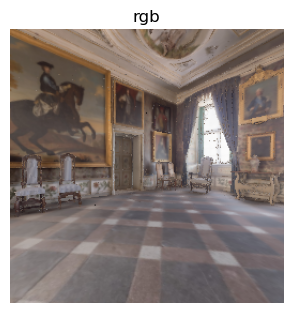

distance to goal: 5.64
angle to goal (radians): 2.88


In [6]:
    action = None
    obs = env.reset()
    valid_actions = ["turn_left", "turn_right", "move_forward", "stop"]
    interactive_control = False  # @param {type:"boolean"}
    while action != "stop":
        display_sample(obs["rgb"])
        print(
            "distance to goal: {:.2f}".format(
                obs["pointgoal_with_gps_compass"][0]
            )
        )
        print(
            "angle to goal (radians): {:.2f}".format(
                obs["pointgoal_with_gps_compass"][1]
            )
        )
        if interactive_control:
            action = input(
                "enter action out of {}:\n".format(", ".join(valid_actions))
            )
            assert (
                action in valid_actions
            ), "invalid action {} entered, choose one amongst " + ",".join(
                valid_actions
            )
        else:
            action = valid_actions.pop()
        obs = env.step(
            {
                "action": action,
            }
        )

    env.close()

In [7]:
    print(env.get_metrics())

{'distance_to_goal': 6.335183143615723, 'success': 0.0, 'spl': 0.0, 'distance_to_goal_reward': -0.0}


## RL Training

In [ ]:
if __name__ == "__main__":
    config = get_baselines_config("pointnav/ppo_pointnav_example.yaml")

In [ ]:
# set random seeds
if __name__ == "__main__":
    seed = "42"  # @param {type:"string"}
    steps_in_thousands = "10"  # @param {type:"string"}

    with habitat.config.read_write(config):
        config.habitat.seed = int(seed)
        config.habitat_baselines.total_num_steps = int(steps_in_thousands)
        config.habitat_baselines.log_interval = 1

    random.seed(config.habitat.seed)
    np.random.seed(config.habitat.seed)

In [ ]:
if __name__ == "__main__":
    trainer_init = baseline_registry.get_trainer(
        config.habitat_baselines.trainer_name
    )
    trainer = trainer_init(config)
    trainer.train()

In [ ]:
# @markdown (double click to see the code)

# example tensorboard visualization
# for more details refer to [link](https://github.com/facebookresearch/habitat-lab/tree/main/habitat-baselines/habitat_baselines#additional-utilities).

try:
    from IPython import display

    with open("./res/img/tensorboard_video_demo.gif", "rb") as f:
        display.display(display.Image(data=f.read(), format="png"))
except ImportError:
    pass

## Key Concepts

All the concepts link to their definitions:

1. [`habitat.sims.habitat_simulator.HabitatSim`](https://github.com/facebookresearch/habitat-lab/blob/main/habitat-lab/habitat/sims/habitat_simulator/habitat_simulator.py#L254)
Thin wrapper over `habitat_sim` providing seamless integration with experimentation framework.


2. [`habitat.core.env.Env`](https://github.com/facebookresearch/habitat-lab/blob/main/habitat-lab/habitat/core/env.py#L26)
Abstraction for the universe of agent, task and simulator. Agents that you train and evaluate operate inside the environment.


3. [`habitat.core.env.RLEnv`](https://github.com/facebookresearch/habitat-lab/blob/main/habitat-lab/habitat/core/env.py#L347)
Extends the `Env` class for reinforcement learning by defining the reward and other required components.


4. [`habitat.core.embodied_task.EmbodiedTask`](https://github.com/facebookresearch/habitat-lab/blob/main/habitat-lab/habitat/core/embodied_task.py#L201)
Defines the task that the agent needs to solve. This class holds the definition of observation space, action space, measures, simulator usage. Eg: PointNav, ObjectNav.


5. [`habitat.core.dataset.Dataset`](https://github.com/facebookresearch/habitat-lab/blob/main/habitat-lab/habitat/core/dataset.py#L107)
Wrapper over information required for the dataset of embodied task, contains definition and interaction with an `episode`.


6. [`habitat.core.embodied_task.Measure`](https://github.com/facebookresearch/habitat-lab/blob/main/habitat-lab/habitat/core/embodied_task.py#L80)
Defines the metrics for embodied task, eg: [SPL](https://github.com/facebookresearch/habitat-lab/blob/main/habitat-lab/habitat/tasks/nav/nav.py#L565).


7. [`habitat_baselines`](https://github.com/facebookresearch/habitat-lab/tree/main/habitat-baselines/habitat_baselines)
RL, SLAM, heuristic baseline implementations for the different embodied tasks.

## Create a new Task

In [ ]:
if __name__ == "__main__":
    config = habitat.get_config(
        config_path=os.path.join(
            dir_path,
            "habitat-lab/habitat/config/benchmark/nav/pointnav/pointnav_habitat_test.yaml",
        ),
        overrides=[
            "habitat.environment.max_episode_steps=10",
            "habitat.environment.iterator_options.shuffle=False",
        ],
    )


@registry.register_task(name="TestNav-v0")
class NewNavigationTask(NavigationTask):
    def __init__(self, config, sim, dataset):
        logger.info("Creating a new type of task")
        super().__init__(config=config, sim=sim, dataset=dataset)

    def _check_episode_is_active(self, *args, **kwargs):
        logger.info(
            "Current agent position: {}".format(self._sim.get_agent_state())
        )
        collision = self._sim.previous_step_collided
        stop_called = not getattr(self, "is_stop_called", False)
        return collision or stop_called


if __name__ == "__main__":
    with habitat.config.read_write(config):
        config.habitat.task.type = "TestNav-v0"

    try:
        env.close()
    except NameError:
        pass
    env = habitat.Env(config=config)

In [ ]:
    action = None
    env.reset()
    valid_actions = ["turn_left", "turn_right", "move_forward", "stop"]
    interactive_control = False  # @param {type:"boolean"}
    while env.episode_over is not True:
        display_sample(obs["rgb"])
        if interactive_control:
            action = input(
                "enter action out of {}:\n".format(", ".join(valid_actions))
            )
            assert (
                action in valid_actions
            ), "invalid action {} entered, choose one amongst " + ",".join(
                valid_actions
            )
        else:
            action = valid_actions.pop()
        obs = env.step(
            {
                "action": action,
                "action_args": None,
            }
        )
        print("Episode over:", env.episode_over)

    env.close()

## Create a new Sensor

In [ ]:
@registry.register_sensor(name="agent_position_sensor")
class AgentPositionSensor(habitat.Sensor):
    def __init__(self, sim, config, **kwargs):
        super().__init__(config=config)
        self._sim = sim

    # Defines the name of the sensor in the sensor suite dictionary
    def _get_uuid(self, *args, **kwargs):
        return "agent_position"

    # Defines the type of the sensor
    def _get_sensor_type(self, *args, **kwargs):
        return habitat.SensorTypes.POSITION

    # Defines the size and range of the observations of the sensor
    def _get_observation_space(self, *args, **kwargs):
        return spaces.Box(
            low=np.finfo(np.float32).min,
            high=np.finfo(np.float32).max,
            shape=(3,),
            dtype=np.float32,
        )

    # This is called whenever reset is called or an action is taken
    def get_observation(self, observations, *args, episode, **kwargs):
        return self._sim.get_agent_state().position

In [ ]:
if __name__ == "__main__":
    config = habitat.get_config(
        config_path=os.path.join(
            dir_path,
            "habitat-lab/habitat/config/benchmark/nav/pointnav/pointnav_habitat_test.yaml",
        ),
        overrides=[
            "habitat.environment.max_episode_steps=10",
            "habitat.environment.iterator_options.shuffle=False",
        ],
    )

    from habitat.config.default_structured_configs import LabSensorConfig

    # We use the base sensor config, but you could also define your own
    # AgentPositionSensorConfig that inherits from LabSensorConfig

    with habitat.config.read_write(config):
        # Now define the config for the sensor
        config.habitat.task.lab_sensors[
            "agent_position_sensor"
        ] = LabSensorConfig(type="agent_position_sensor")

    try:
        env.close()
    except NameError:
        pass
    env = habitat.Env(config=config)

In [ ]:
    obs = env.reset()

In [ ]:
    obs.keys()

In [ ]:
    print(obs["agent_position"])

In [ ]:
    env.close()

## Create a new Agent

In [ ]:
# An example agent which can be submitted to habitat-challenge.
# To participate and for more details refer to:
# - https://aihabitat.org/challenge/2020/
# - https://github.com/facebookresearch/habitat-challenge


class ForwardOnlyAgent(habitat.Agent):
    def __init__(self, success_distance, goal_sensor_uuid):
        self.dist_threshold_to_stop = success_distance
        self.goal_sensor_uuid = goal_sensor_uuid

    def reset(self):
        pass

    def is_goal_reached(self, observations):
        dist = observations[self.goal_sensor_uuid][0]
        return dist <= self.dist_threshold_to_stop

    def act(self, observations):
        if self.is_goal_reached(observations):
            action = HabitatSimActions.stop
        else:
            action = HabitatSimActions.move_forward
        return {"action": action}

### Other Examples

[Create a new action space](https://github.com/facebookresearch/habitat-lab/blob/main/examples/new_actions.py)